In [2]:
# --- Standard libraries
import os
import re
import json
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
# --- Matplotlib
import matplotlib.pyplot as plt
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

'2024.03.5'

### Code functions

In [2]:
def get_xyz_file(directory):
    '''
    Find the file path of the optimized geometry file
    in a given directory
    '''
    # Get a list of all the files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Pattern to find the xyz file
    pattern = r'OPT_[\w]+\.xyz$'
    # Search for the file from pattern
    for file in files:
        if re.match(pattern, file):
            xyz_name = file
            break

    xyz_path = os.path.join(directory, xyz_name)
    return xyz_path

def rearrange_xyz(file_path):
    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''
    # Open the original .xyz file and parse the lines with
    # O and H coordinates to lists
    with open(file_path, 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # Open the .xyz file to write
        with open(file_path, 'w') as fw:

            # Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # Write O coordinates
            for x in o_lines:
                fw.write(x)
            # Write H coordinates
            for y in h_lines:
                fw.write(y)

def analyse_mol(file_path):
    '''
    Take in an XYZ file and extract information: smiles string,
        atom indexes, coordinates, and atomic numbers
    '''
    # Read in and create RDkit mol variable
    mol = MolFromXYZFile(file_path)
    rdDetermineBonds.DetermineBonds(mol)
    Chem.RemoveStereochemistry(mol)
    
    # Get the xyz coordinates of the molecule
    ase_go = read(file_path)
    pos = ase_go.get_positions()
    z = ase_go.get_atomic_numbers()

    # Count the number of carbons in molecule
    num_carbons = np.count_nonzero(z == 6)
    # Create empty array to fill in with atom idxs
    indexes = np.empty([num_carbons, 2])
    # Fill idx array in numerical order
    for x in range(num_carbons):
        indexes[x, :] = x

    # # Set the xyz atom indexing as rdkit map numbers
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())

    # Reload the mol to get the rdkit/networkx atom idx
    smiles = Chem.MolToSmiles(mol)
    new_mol = Chem.MolFromSmiles(smiles)
    # Add the rdkit/networkx index to the corresponding
    # xyz index value in the array
    for atom in new_mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            indexes[atom.GetAtomMapNum(), 1] = atom.GetIdx()

    return smiles, indexes, pos, z

def broaden_spectrum(E, osc):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6
    gE = []

    # Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
        gE.append(tot)
    
    return gE

### Start code

In [9]:
# Path to main folder where all the data is
data_path = '../../work/data/GO_XAS_data/old/circumcoronene/'
# Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Number of molecules in the data set
print(len(subdirs))
# List of paths to all the different molecules
print(subdirs)

92
['../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_0', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_0', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_2', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_2', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_2_ieEPOXY_0_2', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', '../../work/data/GO_XAS_data/old/circumcoronene/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_3_1', '../../work/data/GO_

In [10]:
mol_name = []
# Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# List of all the molecule names
print(mol_name)

92
['cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_2_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_2_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_3_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_4_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0

In [11]:
# Create python dictionaries
final_dict = {}
mol_dict = {}
schnet_dict = {}

# Loop through all the molecule directories
for subdir in tqdm(subdirs):
    dir_path, mol_name = os.path.split(subdir)

    # Get the pathof the xyz file
    xyz_path = get_xyz_file(subdir)
    # Rearrage the xyz file 
    rearrange_xyz(xyz_path)
    # Get the smiles string of mol along with
    # the two different indexes of xyz and rdkit
    smiles, indexes, pos, z = analyse_mol(xyz_path)

    # Get all the individual atom directories for molecule
    atom_direcs = [os.path.join(subdir, d) for d in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, d))]
    # Sort directories in numerical order
    sorted_direcs = natsorted(atom_direcs)
    spec_dict = {}

    # 
    for i in range(len(sorted_direcs)):
        atom_dir = sorted_direcs[i]
        # Get a list of all the files in the directory
        atom_files = [f for f in os.listdir(atom_dir) if os.path.isfile(os.path.join(atom_dir, f))]

        # 
        for file in atom_files:
            if file.endswith('abs.stk'):
                spec_df = pd.read_csv(os.path.join(atom_dir, file), sep='\s+', header=None,
                                      names=['Peaks', 'Strength'])
                # Extract the photon energy and oscilator strength
                energies, osc = spec_df['Peaks'], spec_df['Strength']
                # Broaden the spectra
                gE = broaden_spectrum(energies, osc)
                
                # Normalise the spectra to 1 based on max intenstiy of all spectra
                # for coronene
                # norm_spec = [1.0 * (e / 6471.923222767645) for e in gE]
                # for circumcoronene
                norm_spec = [1.0 * (e / 6924.662753770557) for e in gE]

                # Save as rdkit/networkx indexing
                spec_dict[int(indexes[i, 1])] = norm_spec
    
    final_dict[mol_name] = spec_dict
    mol_dict[mol_name] = smiles      
    schnet_dict[mol_name] = pos.tolist(), z.tolist()   


100%|██████████| 92/92 [01:24<00:00,  1.09it/s]


In [12]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(final_dict)
data.append(schnet_dict)

In [13]:
# --- Save the data into a json file
json.dump(data, codecs.open('./raw/data_circumcoronene.json', 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)

### Check saved data

In [3]:
with open('./raw/data_coronene.json', 'r') as j_file:
    data = json.load(j_file)

In [4]:
# Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_3_ieEPOXY_0_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_1_2', 'R_eO

In [9]:
# View the data stored in the second dictionary for a given key
# mol_name = keys[2]
mol_name = 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2
24
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20', '21', '22', '23', '24'])


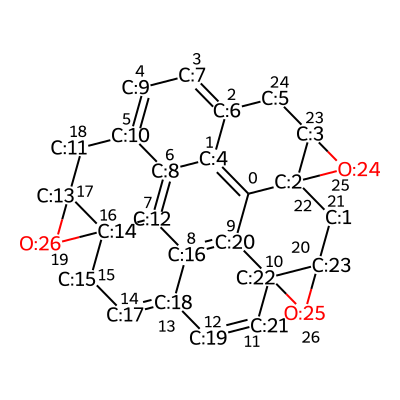

In [10]:
# Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

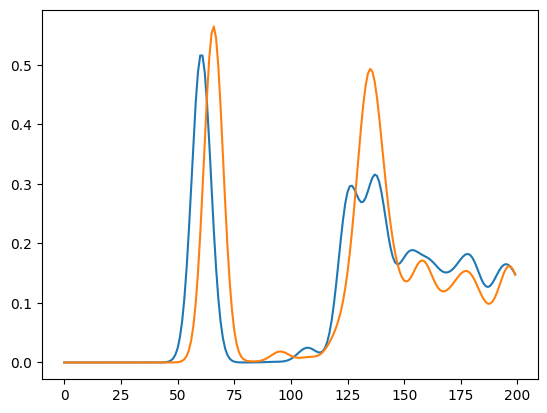

In [12]:
# Plot similar spectra of similar chemical environments
# to check if dictionary is right
plt.plot(data[1][mol_name]['0'])
plt.plot(data[1][mol_name]['1'])
# plt.plot(data[1][mol_name]['25'])
plt.show()